
# Jelly Pin‑Up — Analytics Notebook

Этот ноутбук строит полную статистику по базе `scores.sqlite`:

- загрузка таблиц `runs`, `prompts`, `scores`;
- разбор JSON‑параметров (гены, сессии, опции);
- сводные таблицы и метрики;
- графики распределений и временные ряды;
- scatter диаграммы и **тепловые карты** (heatmaps) для комбинаций генов;
- выборка `NOIMG` записей (когда изображение не вернулось);
- топ‑комбинации и топ‑промпты по fitness.

> Примечание: графики построены **на matplotlib** (без seaborn), один график на фигуру, без ручной установки цветов.


In [17]:

from pathlib import Path
import sqlite3, json, math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

DB_PATH = Path('./scores.sqlite')  # поменяйте путь при необходимости

pd.set_option('display.max_colwidth', 120)
print('DB_PATH =', DB_PATH.resolve())


DB_PATH = C:\Users\petyl\OneDrive\Desktop\Drafts\fisheye-jelly-pop-girls\scores.sqlite


In [18]:

def load_tables(db_path: Path):
    if not db_path.exists():
        print('WARNING: DB not found:', db_path)
        return pd.DataFrame(), pd.DataFrame(), pd.DataFrame()
    con = sqlite3.connect(db_path)
    try:
        runs = pd.read_sql_query('SELECT * FROM runs', con)
    except Exception:
        runs = pd.DataFrame()
    try:
        prompts = pd.read_sql_query('SELECT * FROM prompts', con)
    except Exception:
        prompts = pd.DataFrame()
    try:
        scores = pd.read_sql_query('SELECT * FROM scores', con)
    except Exception:
        scores = pd.DataFrame()
    con.close()
    return runs, prompts, scores

runs, prompts, scores = load_tables(DB_PATH)
print('rows: runs', len(runs), 'prompts', len(prompts), 'scores', len(scores))
runs.head(3)


rows: runs 13 prompts 320 scores 328


,session_id,started_ts,mode,cfg_json
0,evolve-1760747177,1760747177,evolve,"{""pop"": 16, ""gens"": 4, ""keep"": 0.25, ""mut"": 0.15, ""xover"": 0.3, ""sfw"": 0.6, ""temperature"": 0.55, ""weights"": {""style""..."
1,evolve-1760748965,1760748965,evolve,"{""pop"": 16, ""gens"": 8, ""keep"": 0.25, ""mut"": 0.2, ""xover"": 0.3, ""sfw"": 0.75, ""temperature"": 0.55, ""weights"": {""style""..."
2,evolve-1760749520,1760749520,evolve,"{""pop"": 16, ""gens"": 4, ""keep"": 0.25, ""mut"": 0.2, ""xover"": 0.3, ""sfw"": 0.75, ""temperature"": 0.55, ""weights"": {""style""..."


In [19]:

def extract_from_params(params_str):
    try:
        p = json.loads(params_str)
    except Exception:
        return {}
    out = {}
    out['session'] = p.get('session')
    struct = p.get('struct', {})
    genes = struct.get('gene_ids', {})
    for k,v in genes.items():
        out[f'gene_{k}'] = v
    # aspect
    if 'aspect_ratio' in struct:
        out['aspect_ratio'] = struct['aspect_ratio']
    return out

if not prompts.empty:
    extra = prompts['params'].apply(extract_from_params).apply(pd.Series)
    prompts_ext = pd.concat([prompts.drop(columns=['params']), extra], axis=1)
else:
    prompts_ext = prompts.copy()

print('prompts_ext columns:', prompts_ext.columns.tolist()[:16], '...')
prompts_ext.head(3)


prompts_ext columns: ['path', 'ts', 'gen', 'indiv', 'prompt', 'sfw', 'temperature', 'weights_style', 'weights_nsfw', 'fitness', 'parents', 'op', 'session', 'gene_palette', 'gene_lighting', 'gene_background'] ...


,path,ts,gen,indiv,prompt,sfw,temperature,weights_style,weights_nsfw,fitness,...,gene_lighting,gene_background,gene_camera_angle,gene_camera_framing,gene_lens,gene_depth,gene_mood,gene_pose,gene_action,aspect_ratio
0,output\G01-I02_1.jpg,1760747217,1,2,"The centerfold-classy glam model lounges on a chaise with one knee up, her modest backless dress secured at the fron...",0.6,0.55,0.75,0.25,59.25,...,window_morning,sunstrip,floor_peek,medium_34,wide_35,crisp_f4,noir_mousse,recline_elbow,neckline_adjust,4:3
1,output\G01-I03_1.jpg,1760747233,1,3,"The retro pin-up illustration captures a candy-crush cool girl lounging seductively on a bar stool, her structured c...",0.6,0.55,0.75,0.25,51.75,...,ring_triplet,silk_drape,hip_line,tall_916,wide_35,soft_f2_8,tease_light,bridge_arc,zip_slide_back,3:4
2,output\G01-I04_1.jpg,1760747245,1,4,"The sultry illustration captures a powder-soft glamour model straddling a chair back, arms folded over her top. She ...",0.6,0.55,0.75,0.25,55.25,...,silver_bounce,wet_acrylic,low_glam,tall_916,mild_tele_105,cream_f1_8,tease_light,palm_brace,collarbone_trace,9:16


In [20]:

# path в scores и prompts совпадает для картинок; для NOIMG в prompts path начинается с 'NOIMG:'
if not scores.empty:
    scores['is_noimg'] = scores['path'].str.startswith('NOIMG:', na=False)
if not prompts_ext.empty:
    prompts_ext['is_noimg'] = prompts_ext['path'].str.startswith('NOIMG:', na=False)

merged = None
if not scores.empty and not prompts_ext.empty:
    merged = prompts_ext.merge(scores, on='path', how='left', suffixes=('', '_sc'))
    print('merged rows:', len(merged))
else:
    merged = prompts_ext.copy()

merged.head(3)


merged rows: 320


,path,ts,gen,indiv,prompt,sfw,temperature,weights_style,weights_nsfw,fitness,...,is_noimg,id,ts_sc,nsfw,style,clip_style,specular,illu_bias,notes,is_noimg_sc
0,output\G01-I02_1.jpg,1760747217,1,2,"The centerfold-classy glam model lounges on a chaise with one knee up, her modest backless dress secured at the fron...",0.6,0.55,0.75,0.25,59.25,...,False,13,1760747215,72.0,55.0,62.0,47.0,50.0,imagen jelly pin-up,False
1,output\G01-I03_1.jpg,1760747233,1,3,"The retro pin-up illustration captures a candy-crush cool girl lounging seductively on a bar stool, her structured c...",0.6,0.55,0.75,0.25,51.75,...,False,14,1760747232,27.0,60.0,62.0,60.0,50.0,imagen jelly pin-up,False
2,output\G01-I04_1.jpg,1760747245,1,4,"The sultry illustration captures a powder-soft glamour model straddling a chair back, arms folded over her top. She ...",0.6,0.55,0.75,0.25,55.25,...,False,15,1760747245,53.0,56.0,62.0,47.0,51.0,imagen jelly pin-up,False


In [21]:

def describe_df(df, cols):
    desc = {}
    for c in cols:
        if c in df.columns:
            s = df[c].dropna()
            if len(s)==0:
                desc[c] = {'count':0}
            else:
                desc[c] = {
                    'count': int(s.count()),
                    'mean': float(s.mean()),
                    'std': float(s.std(ddof=1)) if s.count()>1 else None,
                    'min': float(s.min()),
                    'p25': float(s.quantile(0.25)),
                    'p50': float(s.quantile(0.50)),
                    'p75': float(s.quantile(0.75)),
                    'max': float(s.max())
                }
    return pd.DataFrame(desc).T

NUM_COLS = ['fitness','style','nsfw','clip_style','specular','illu_bias']
stats = describe_df(merged, NUM_COLS) if not merged.empty else pd.DataFrame()
stats


,count,mean,std,min,p25,p50,p75,max
fitness,320.0,60.035156,12.788893,32.1,51.075,59.325,68.70,105.6
style,320.0,60.618750,6.435961,44.0,56.000,61.000,66.00,75.0
nsfw,320.0,33.118750,26.147009,0.0,9.000,30.000,52.25,99.0
clip_style,320.0,66.003125,7.874604,40.0,61.000,65.000,72.00,83.0
specular,320.0,52.575000,5.423795,46.0,48.000,51.000,58.00,62.0
illu_bias,320.0,56.562500,10.951696,28.0,50.000,60.000,65.25,74.0


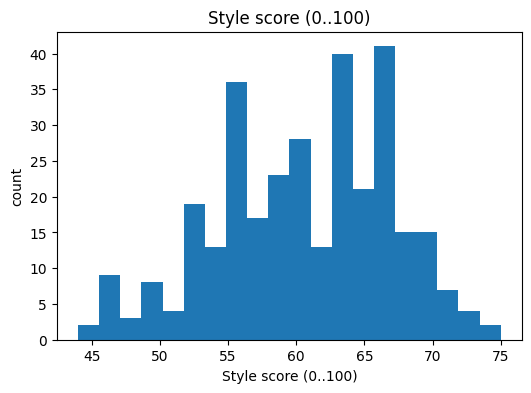

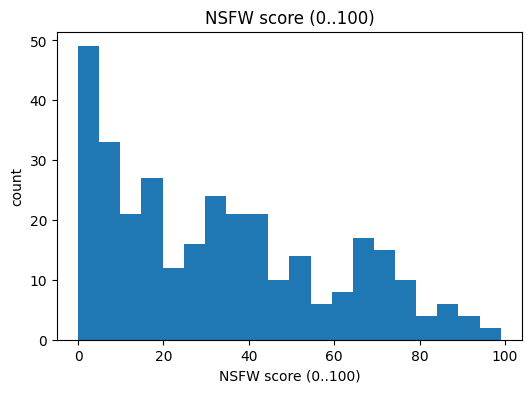

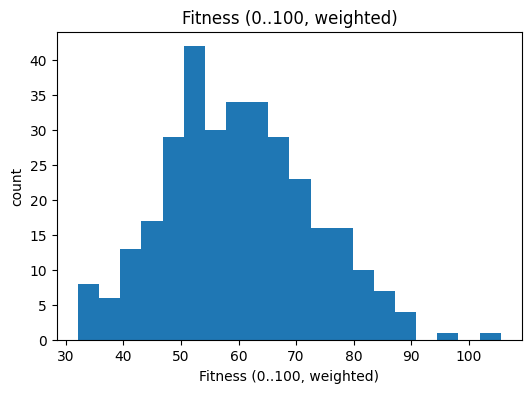

In [22]:

def hist_one(series, title):
    if series is None or series.empty:
        print('No data for', title); return
    plt.figure(figsize=(6,4))
    plt.hist(series.dropna().values, bins=20)
    plt.title(title)
    plt.xlabel(title)
    plt.ylabel('count')
    plt.show()

if not merged.empty:
    hist_one(merged['style'], 'Style score (0..100)')
    hist_one(merged['nsfw'], 'NSFW score (0..100)')
    hist_one(merged['fitness'], 'Fitness (0..100, weighted)')


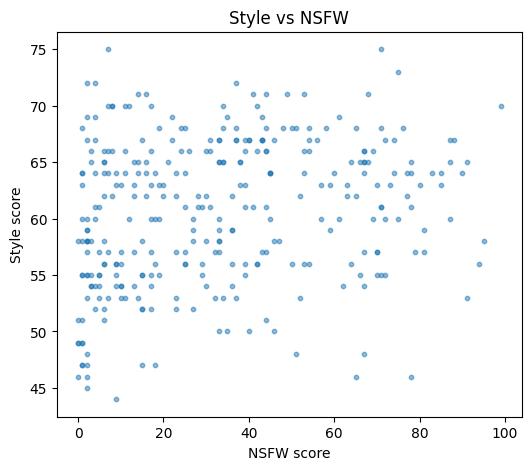

In [23]:

if not merged.empty:
    plt.figure(figsize=(6,5))
    plt.scatter(merged['nsfw'], merged['style'], alpha=0.5, s=10)
    plt.xlabel('NSFW score')
    plt.ylabel('Style score')
    plt.title('Style vs NSFW')
    plt.show()


In [24]:

def agg_by_session(df):
    if df is None or df.empty: return pd.DataFrame()
    if 'session' not in df.columns:
        return pd.DataFrame()
    g = df.groupby('session', dropna=False).agg(
        n=('path','count'),
        style_mean=('style','mean'),
        nsfw_mean=('nsfw','mean'),
        fitness_mean=('fitness','mean')
    ).reset_index().sort_values('fitness_mean', ascending=False)
    return g

sessions = agg_by_session(merged)
sessions.head(10)


,session,n,style_mean,nsfw_mean,fitness_mean
1,evolve-1760748965,6,56.666667,41.166667,78.266667
3,evolve-1760751141,18,63.000000,42.611111,69.483333
5,evolve-1760780868,14,59.357143,29.714286,68.271429
2,evolve-1760749520,33,57.151515,35.363636,65.581818
4,evolve-1760751864,104,61.701923,31.490385,64.978846
7,evolve-1760782436,5,67.000000,31.800000,56.440000
8,evolve-1760782710,41,61.487805,32.804878,52.882927
9,evolve-1760783779,44,63.022727,29.159091,52.863636
0,evolve-1760747177,40,57.225000,36.050000,51.931250
6,evolve-1760782193,1,72.000000,4.000000,51.600000


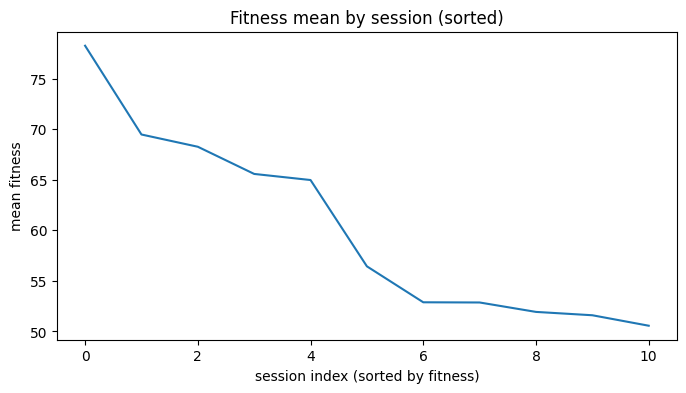

In [25]:

if not sessions.empty:
    plt.figure(figsize=(8,4))
    plt.plot(range(len(sessions)), sessions['fitness_mean'])
    plt.title('Fitness mean by session (sorted)')
    plt.xlabel('session index (sorted by fitness)')
    plt.ylabel('mean fitness')
    plt.show()


In [26]:

if not prompts_ext.empty:
    top_prompts = prompts_ext[~prompts_ext['is_noimg']].copy() if 'is_noimg' in prompts_ext else prompts_ext.copy()
    if 'fitness' in top_prompts.columns:
        top_prompts = top_prompts.sort_values('fitness', ascending=False).head(20)
        cols = ['path','gen','indiv','fitness','sfw','temperature','prompt']
        display(top_prompts[cols])
    else:
        print('No fitness column in prompts table')


,path,gen,indiv,fitness,sfw,temperature,prompt
43,evol-1\G02-I06_1.jpg,2,6,105.6,0.75,0.55,"From a floor-level angle, the long silhouette captures a cover girl’s slow-burn wink as she leans forward, palms res..."
42,evol-1\G01-I09_1.jpg,1,9,96.0,0.75,0.55,"The supine mini-bridge pose of the fresh sunlit model, her high-waist bikini set with a structured opaque top, is ca..."
209,evol-3-1\G03-I02_1.jpg,3,2,88.9,0.25,0.55,"The retro-chic model sits seductively on a high stool, her modest dance leotard contrasting with delicate lace glove..."
66,evol-1\G03-I04_1.jpg,3,4,88.8,0.75,0.55,"The retro pin-up illustration, with its glossy watercolor finish and paper texture, captures a bold cover-girl wink ..."
172,evol-3\G08-I03_1.jpg,8,3,88.2,0.60,0.55,"The illustration captures a model in a powder-soft glamour look, lounging on a chaise with one knee up and a playful..."
75,evol-1\G04-I08_1.jpg,4,8,88.0,0.75,0.55,"The retro pin-up illustration in a glossy, lacquered watercolor jelly-art style captures a cover-girl's wink look as..."
163,evol-3\G07-I04_1.jpg,7,4,86.7,0.60,0.55,"The illustration captures a powder-soft glamour look model kneeling side profile, hips on heels, torso twisted towar..."
110,evol-3\G02-I07_1.jpg,2,7,85.8,0.60,0.55,"The retro pin-up illustration, rendered in lacquered watercolor jelly-art with chrome-wet speculars, captures a cove..."
85,evol-2\G02-I03_1.jpg,2,3,84.6,0.60,0.55,"The retro pin-up illustration captures a cover-girl wink look on a model perched seductively on a bar stool, her str..."
134,evol-3\G04-I13_1.jpg,4,13,84.3,0.60,0.55,"In an over-shoulder shot with elongated lines and a 9:16 ratio, the glossy watercolor illustration captures a candy-..."


In [27]:

if not prompts_ext.empty and 'is_noimg' in prompts_ext.columns:
    noimg = prompts_ext[prompts_ext['is_noimg']].copy()
    noimg = noimg.sort_values('ts', ascending=False).head(20)
    cols = ['path','gen','indiv','ts','sfw','temperature','prompt','op']
    display(noimg[cols])


,path,gen,indiv,ts,sfw,temperature,prompt,op


In [28]:

def pivot_heatmap(df, row_key, col_key, val_key, top_rows=10, top_cols=10, min_count=3):
    if df.empty or row_key not in df.columns or col_key not in df.columns or val_key not in df.columns:
        print('pivot_heatmap: missing columns or empty df'); return
    # Count combinations
    cnt = df.groupby([row_key, col_key])[val_key].count().reset_index(name='n')
    # pick top rows/cols by frequency
    top_r = cnt.groupby(row_key)['n'].sum().sort_values(ascending=False).head(top_rows).index.tolist()
    top_c = cnt.groupby(col_key)['n'].sum().sort_values(ascending=False).head(top_cols).index.tolist()
    sub = df[df[row_key].isin(top_r) & df[col_key].isin(top_c)]
    if sub.empty:
        print('nothing to show'); return
    pv = sub.pivot_table(index=row_key, columns=col_key, values=val_key, aggfunc='mean')
    # mask too-sparse cells
    nmat = sub.pivot_table(index=row_key, columns=col_key, values=val_key, aggfunc='count').reindex_like(pv).fillna(0)
    pv = pv.where(nmat >= min_count)
    # plot
    plt.figure(figsize=(1.2*len(top_c)+2, 1.2*len(top_r)+2))
    img = plt.imshow(pv.values, aspect='auto')
    plt.xticks(ticks=range(len(pv.columns)), labels=pv.columns, rotation=45, ha='right')
    plt.yticks(ticks=range(len(pv.index)), labels=pv.index)
    plt.title(f'Heatmap: mean {val_key} by {row_key} x {col_key} (min n={min_count})')
    plt.colorbar(img)
    plt.tight_layout()
    plt.show()

# Добавляем читаемые ключи из gene_* колонок
if not merged.empty:
    for k in ['palette','lighting','background','camera_angle','camera_framing','pose','action']:
        col = f'gene_{k}'
        if col not in merged.columns and col in prompts_ext.columns:
            merged[col] = prompts_ext[col]


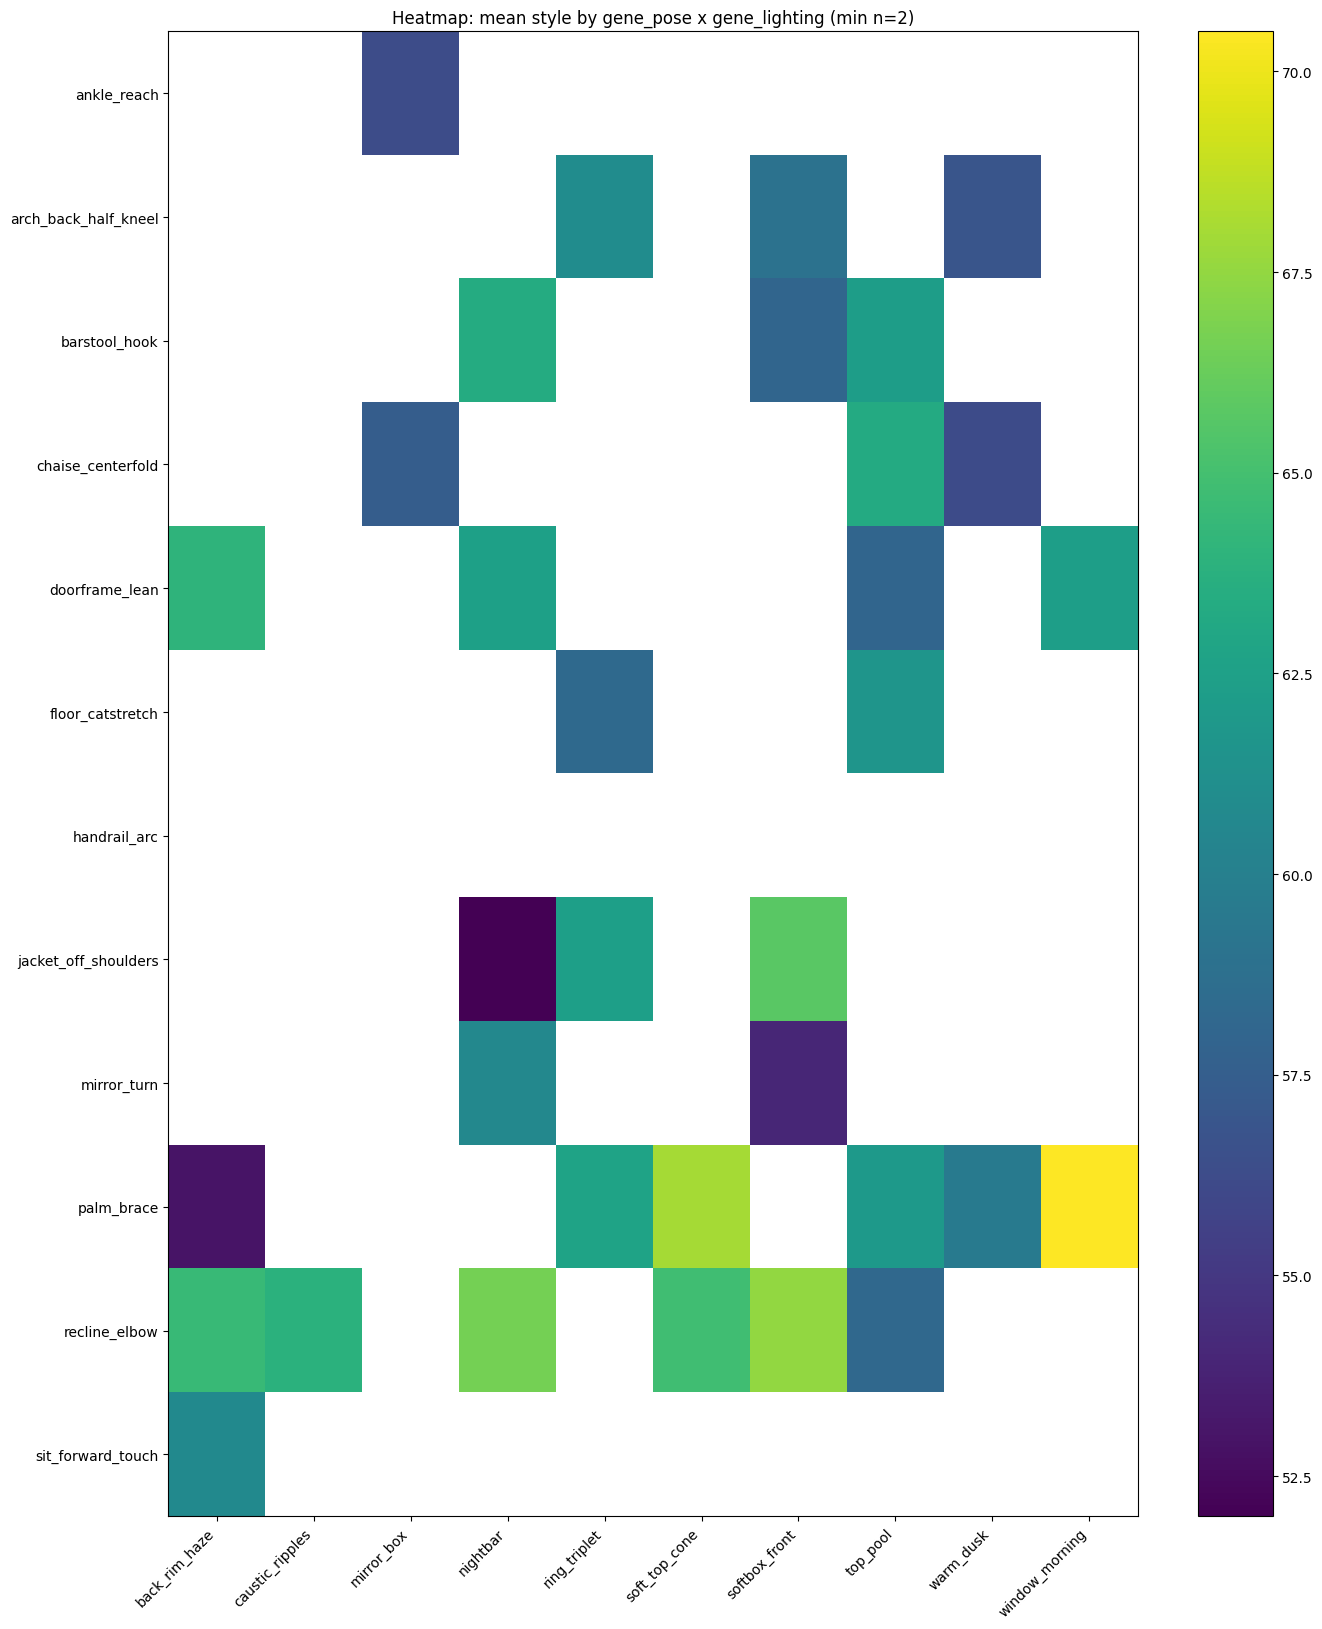

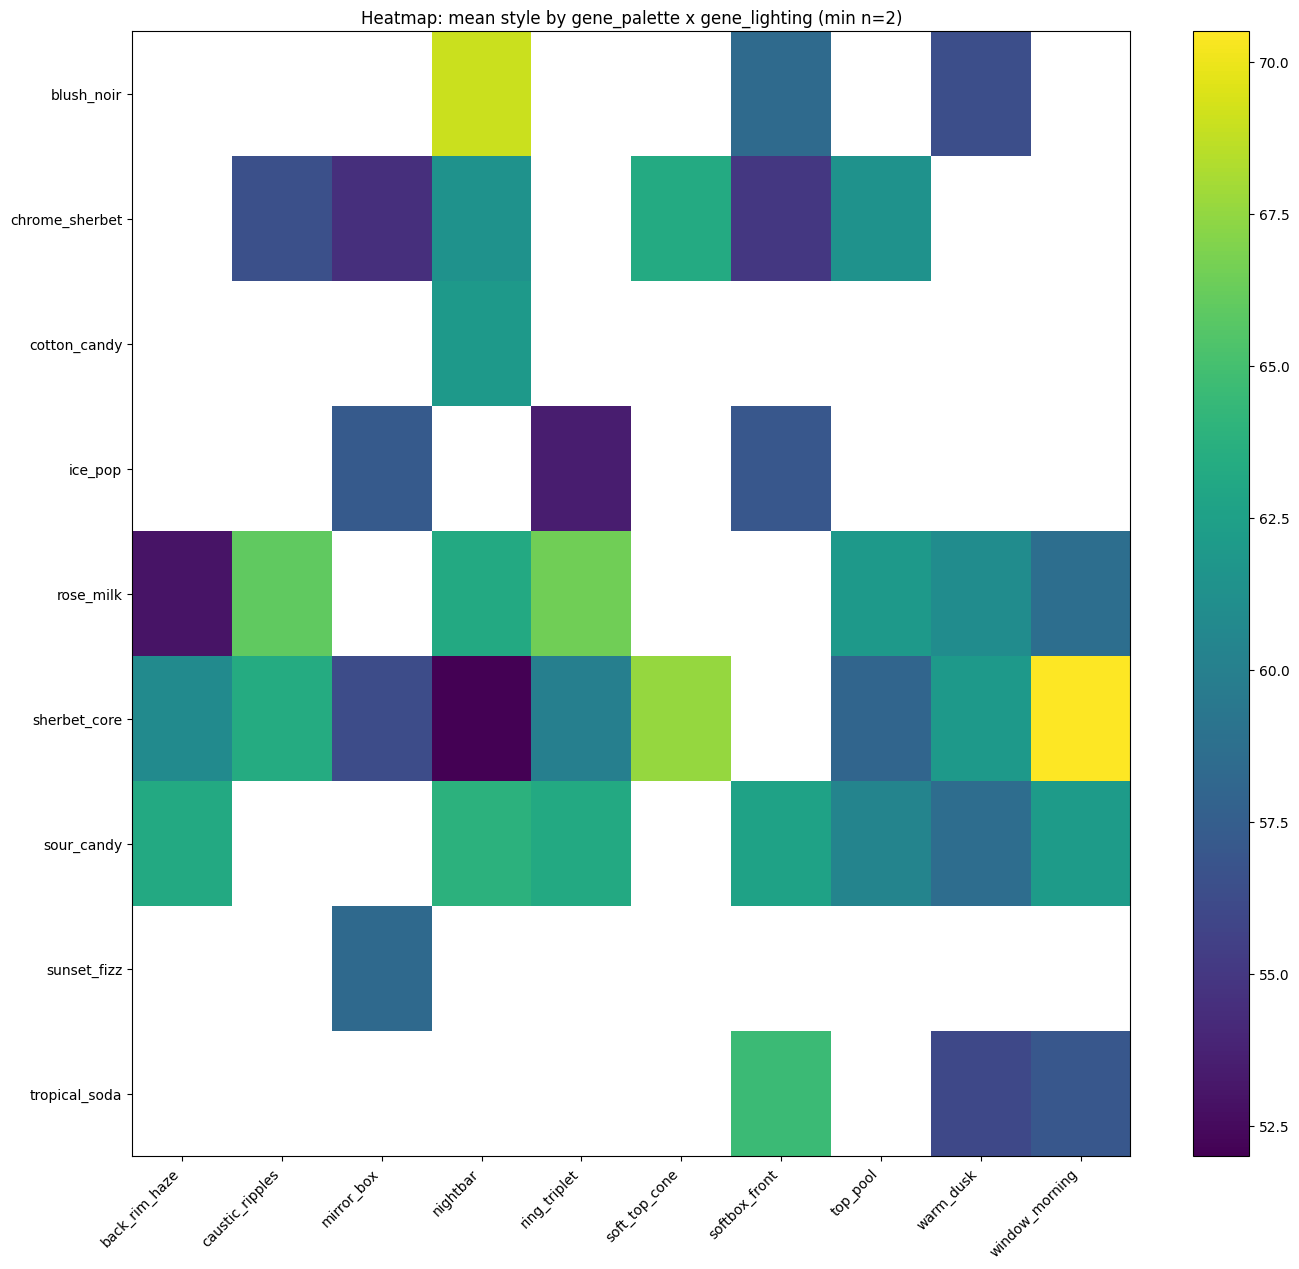

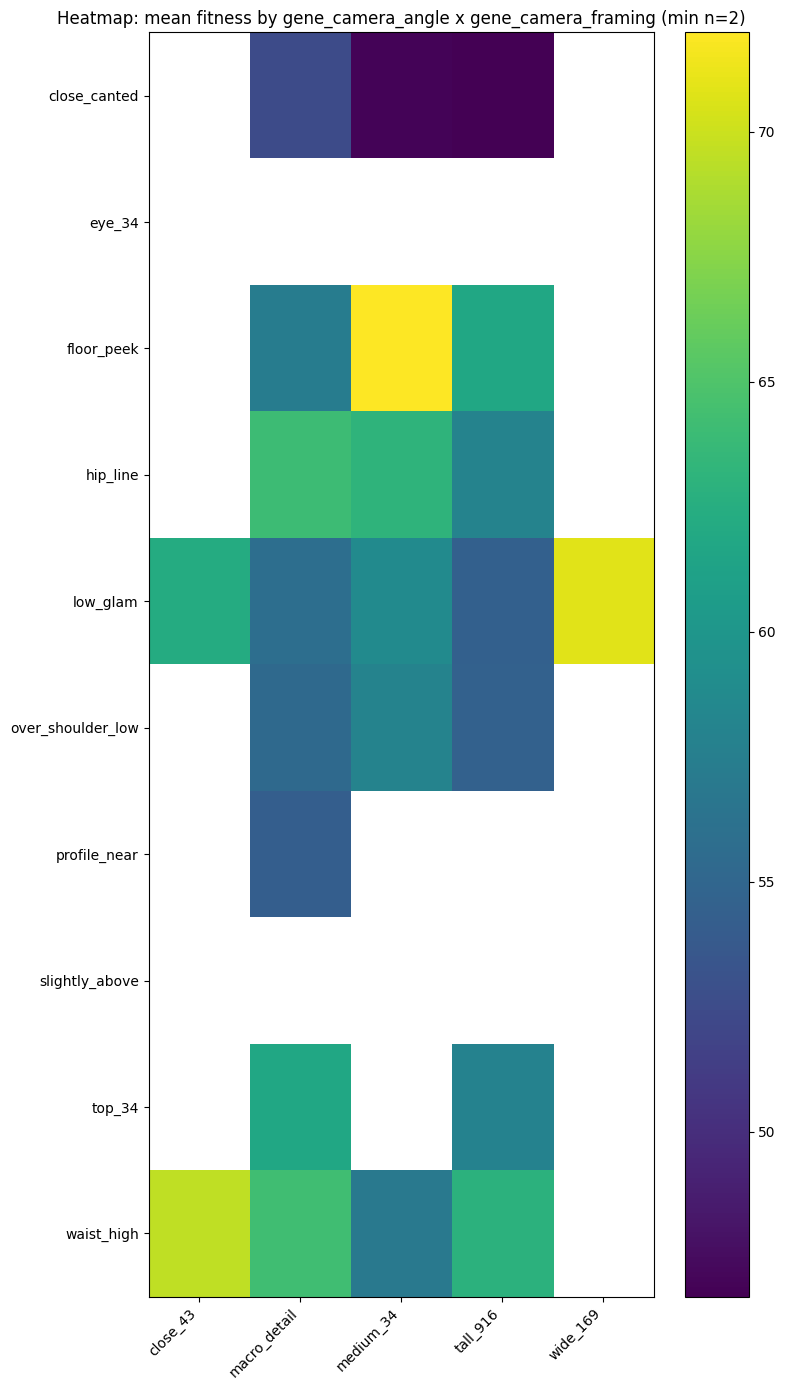

In [29]:

if not merged.empty:
    pivot_heatmap(merged, 'gene_pose', 'gene_lighting', 'style', top_rows=12, top_cols=10, min_count=2)
    pivot_heatmap(merged, 'gene_palette', 'gene_lighting', 'style', top_rows=10, top_cols=10, min_count=2)
    pivot_heatmap(merged, 'gene_camera_angle', 'gene_camera_framing', 'fitness', top_rows=10, top_cols=10, min_count=2)


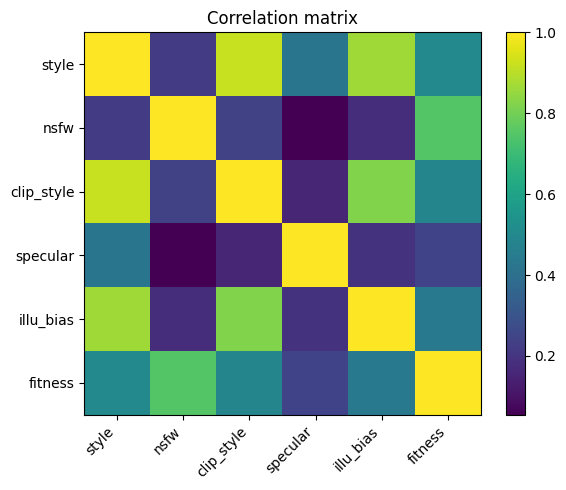

In [30]:

if not merged.empty:
    nums = merged[['style','nsfw','clip_style','specular','illu_bias','fitness']].dropna()
    if not nums.empty:
        corr = nums.corr()
        plt.figure(figsize=(6,5))
        plt.imshow(corr.values, aspect='auto')
        plt.xticks(range(corr.shape[1]), corr.columns, rotation=45, ha='right')
        plt.yticks(range(corr.shape[0]), corr.index)
        plt.title('Correlation matrix')
        plt.colorbar()
        plt.tight_layout()
        plt.show()
        corr


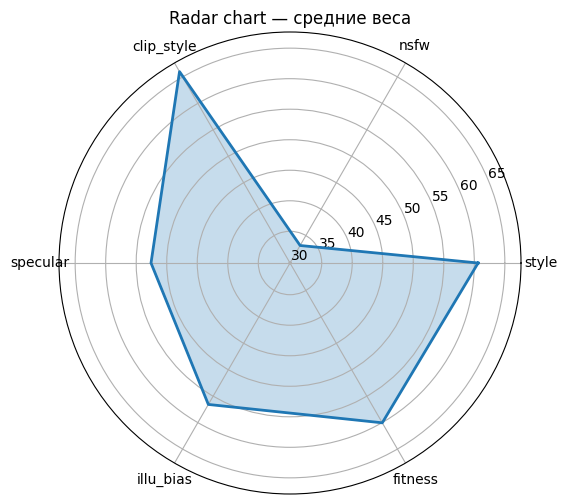

In [31]:
# Radar chart with average weights
if not merged.empty:
    weight_cols = [c for c in ['style','nsfw','clip_style','specular','illu_bias','fitness'] if c in merged.columns]
    weight_values = merged[weight_cols].dropna() if weight_cols else pd.DataFrame()
    if not weight_values.empty:
        means = weight_values.mean()
        categories = means.index.tolist()
        values = means.values.astype(float)
        angles = np.linspace(0, 2 * np.pi, len(categories) + 1)
        values = np.append(values, values[0])
        fig, ax = plt.subplots(figsize=(6, 6), subplot_kw={'projection': 'polar'})
        ax.plot(angles, values, color='tab:blue', linewidth=2)
        ax.fill(angles, values, color='tab:blue', alpha=0.25)
        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(categories)
        ax.set_title('Radar chart — средние веса')
        min_val = max(0.0, float(values.min()) - 0.1 * abs(float(values.min())))
        ax.set_ylim(bottom=min_val)
        plt.show()
        means


In [32]:
# Radar chart for option combinations
if not merged.empty:
    gene_cols = [c for c in merged.columns if c.startswith('gene_')]
    numeric_gene_cols = [c for c in gene_cols if merged[c].dropna().size and pd.api.types.is_numeric_dtype(merged[c])]
    combo_frame = merged[numeric_gene_cols + ['fitness']] if numeric_gene_cols else pd.DataFrame()
    combo_frame = combo_frame.dropna() if not combo_frame.empty else combo_frame
    if not combo_frame.empty:
        grouped = combo_frame.groupby(numeric_gene_cols).agg({'fitness': 'mean'}).reset_index()
        top_combos = grouped.sort_values('fitness', ascending=False).head(3)
        ranges = combo_frame[numeric_gene_cols].agg(['min', 'max'])
        denom = (ranges.loc['max'] - ranges.loc['min']).replace(0, 1)
        angles = np.linspace(0, 2 * np.pi, len(numeric_gene_cols) + 1)
        fig, ax = plt.subplots(figsize=(7, 7), subplot_kw={'projection': 'polar'})
        for _, row in top_combos.iterrows():
            norm_vals = (row[numeric_gene_cols] - ranges.loc['min']) / denom
            norm_vals = norm_vals.fillna(0).values.astype(float)
            values = np.append(norm_vals, norm_vals[0])
            ax.plot(angles, values, linewidth=2, label=f"fit={row['fitness']:.2f}")
            ax.fill(angles, values, alpha=0.15)
        ax.set_xticks(angles[:-1])
        ax.set_xticklabels([c.replace('gene_', '') for c in numeric_gene_cols])
        ax.set_title('Radar chart — комбинации опций (нормировано)')
        ax.set_ylim(0, 1)
        ax.legend(loc='upper right', bbox_to_anchor=(1.35, 1.1))
        plt.show()
        top_combos



## Быстрый фильтр по сессии

Запустите ячейку ниже и укажите `SESSION_ID`, чтобы анализировать конкретный запуск.


In [33]:

SESSION_ID = None  # например: 'evolve-1734567900'

if SESSION_ID and 'session' in merged.columns:
    m = merged[merged['session']==SESSION_ID].copy()
else:
    m = merged.copy()

print('rows selected:', len(m))
m.head(3)


rows selected: 320


,path,ts,gen,indiv,prompt,sfw,temperature,weights_style,weights_nsfw,fitness,...,is_noimg,id,ts_sc,nsfw,style,clip_style,specular,illu_bias,notes,is_noimg_sc
0,output\G01-I02_1.jpg,1760747217,1,2,"The centerfold-classy glam model lounges on a chaise with one knee up, her modest backless dress secured at the fron...",0.6,0.55,0.75,0.25,59.25,...,False,13,1760747215,72.0,55.0,62.0,47.0,50.0,imagen jelly pin-up,False
1,output\G01-I03_1.jpg,1760747233,1,3,"The retro pin-up illustration captures a candy-crush cool girl lounging seductively on a bar stool, her structured c...",0.6,0.55,0.75,0.25,51.75,...,False,14,1760747232,27.0,60.0,62.0,60.0,50.0,imagen jelly pin-up,False
2,output\G01-I04_1.jpg,1760747245,1,4,"The sultry illustration captures a powder-soft glamour model straddling a chair back, arms folded over her top. She ...",0.6,0.55,0.75,0.25,55.25,...,False,15,1760747245,53.0,56.0,62.0,47.0,51.0,imagen jelly pin-up,False


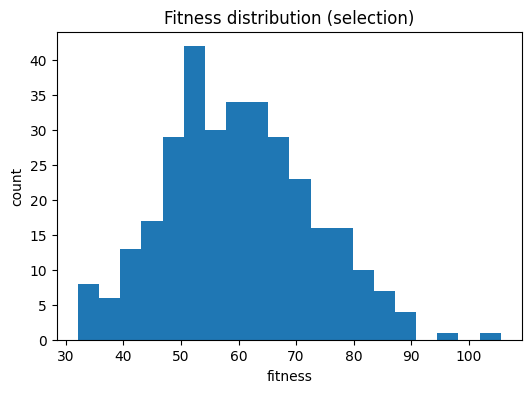

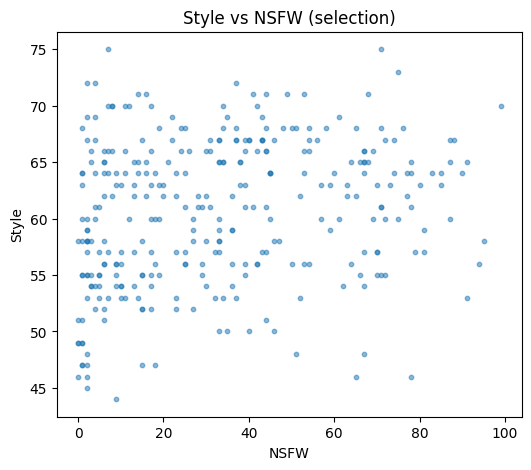

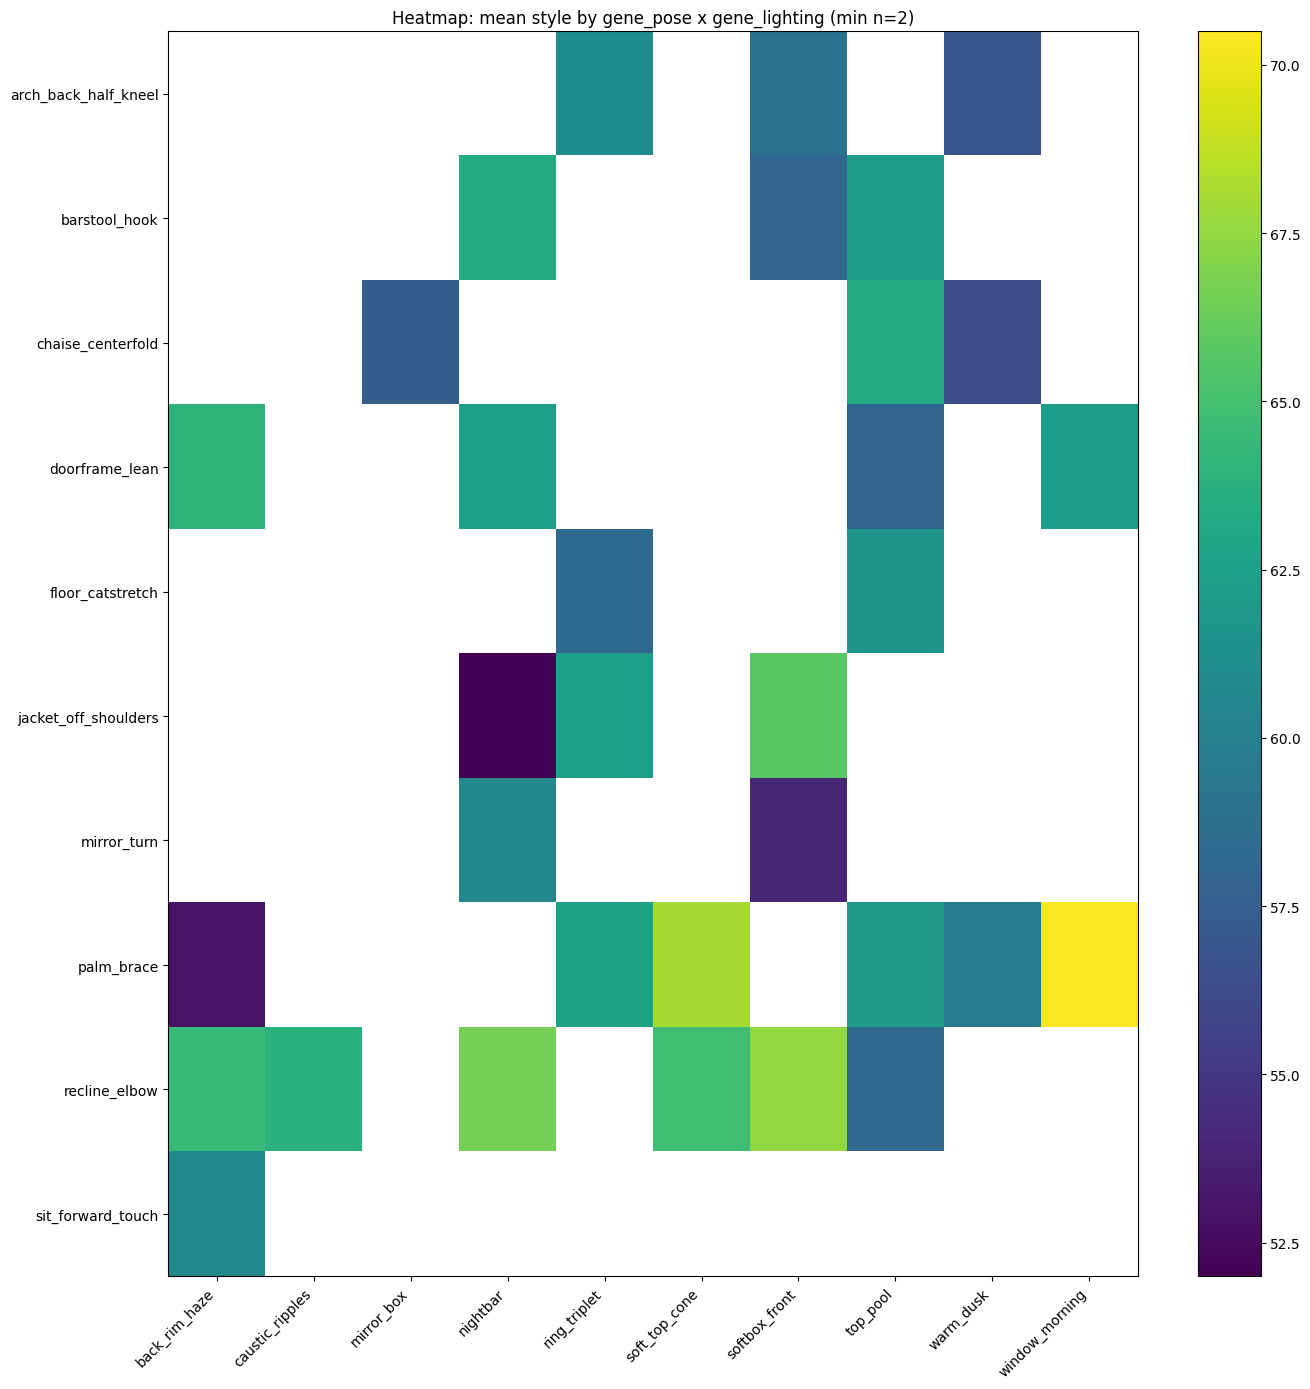

In [34]:

if not m.empty:
    plt.figure(figsize=(6,4))
    plt.hist(m['fitness'].dropna().values, bins=20)
    plt.title('Fitness distribution (selection)')
    plt.xlabel('fitness'); plt.ylabel('count')
    plt.show()

    plt.figure(figsize=(6,5))
    plt.scatter(m['nsfw'], m['style'], alpha=0.5, s=10)
    plt.xlabel('NSFW'); plt.ylabel('Style'); plt.title('Style vs NSFW (selection)')
    plt.show()

    pivot_heatmap(m, 'gene_pose', 'gene_lighting', 'style', top_rows=10, top_cols=10, min_count=2)
